In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import plotly.express as px
import plotly.graph_objects as go

import os
print(os.listdir("../data"))
import warnings
warnings.filterwarnings('ignore')

['IMDB Dataset.csv']


In [2]:
df=pd.read_csv('../data/IMDB Dataset.csv')
print("Data shape: ", df.shape) # Total review
df

Data shape:  (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
df['clean_review'] = df['review']
df['clean_review'].head()

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: clean_review, dtype: str

In [4]:
def clean_text(s: str) -> str:
    """
    Cleans text using regex.
    :param s: string
    :return: text
    """

    s = s.lower()
    s = re.sub('<.*?>',' ', s) # Remove HTML tags
    s = re.sub('[^a-zA-Z]', ' ', s) # Remove punctuation & number
    s = re.sub(r'\s+',' ', s) # Normalize whitespace
    return s.strip()

In [5]:
df["clean_review"] = df["clean_review"].apply(clean_text)
df["clean_review"].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically there s a family where a little boy ...
4    petter mattei s love in the time of money is a...
Name: clean_review, dtype: str

In [6]:
X = df['clean_review']
y = df['sentiment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [8]:
tfidf_uni = TfidfVectorizer(
    ngram_range=(1,1),
    min_df=2,
    max_df=0.95,
    max_features=30000,
)

X_train_uni = tfidf_uni.fit_transform(X_train)
X_test_uni  = tfidf_uni.transform(X_test)

In [9]:
tfidf_bi = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95,
    max_features=50000,
)

X_train_bi = tfidf_bi.fit_transform(X_train)
X_test_bi  = tfidf_bi.transform(X_test)

In [10]:
# Logistic Regression
lr_uni = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_uni.fit(X_train_uni, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [11]:
y_pred_uni = lr_uni.predict(X_test_uni)

# classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_uni))
print(classification_report(y_test, y_pred_uni))

Accuracy: 0.9004
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.90      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



- The accuracy is pretty good: 0.9
- Precision, Recall, F1 score is high
- macro avg and weighted avg is balance

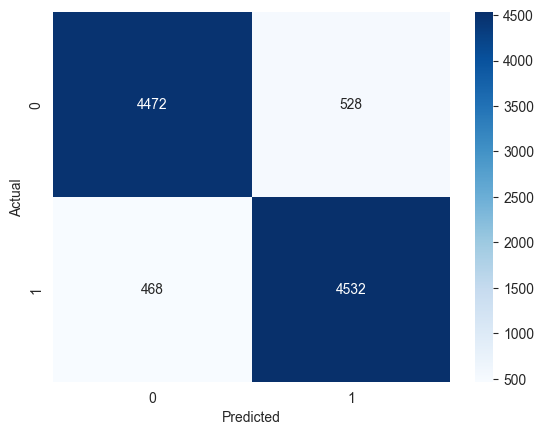

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_uni)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- TP and TN is high
- FP and FN is somewhat 10%

In [13]:
# roc - auc
y_prob_uni = lr_uni.predict_proba(X_test_uni)[:,1]

roc_auc = roc_auc_score(y_test, y_prob_uni)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.96344208


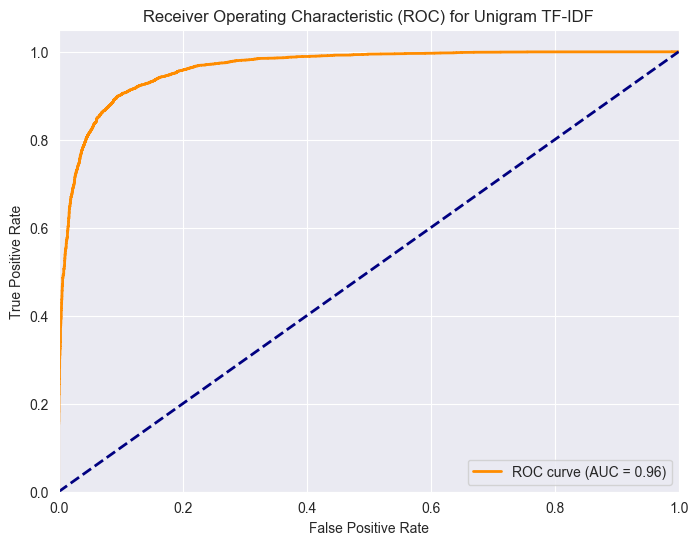

In [14]:
y_true_mapped = np.where(y_test == 'positive', 1, 0) # convert y_test to binary
fpr, tpr, _ = roc_curve(y_true_mapped, y_prob_uni)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Unigram TF-IDF')
plt.legend(loc="lower right")
plt.legend()

- Range 0.5-1.0: 0.96 is very good
- The model perform good to know the difference between positive and negative

In [15]:
feature_names = tfidf_uni.get_feature_names_out()
coef = lr_uni.coef_[0]

df_coef = pd.DataFrame({'word': feature_names, 'coef': coef})

top_20_neg = df_coef.sort_values(by='coef').head(20)


In [16]:
fig = px.bar(top_20_neg,
             x='coef',
             y='word',
             title='Top 20 Negative Words (Strongest Predictors)')

fig.show()

In [17]:
top_20_pos = df_coef.sort_values(by='coef').tail(20)

In [18]:
fig = px.bar(top_20_pos,
             x='coef',
             y='word',
             title='Top 20 Positive Words (Strongest Predictors)')

fig.show()

In [19]:
# Compare with bi-gram

lr_bi = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_bi.fit(X_train_bi, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [20]:
y_pred_bi = lr_bi.predict(X_test_bi)

# classification_report
print("Accuracy:", accuracy_score(y_test, y_pred_bi))
print(classification_report(y_test, y_pred_bi))

Accuracy: 0.9079
              precision    recall  f1-score   support

    negative       0.91      0.90      0.91      5000
    positive       0.90      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



- The accuracy is higher: 0.91
- Precision, Recall, F1 score is high and better
- macro avg and weighted avg is balance

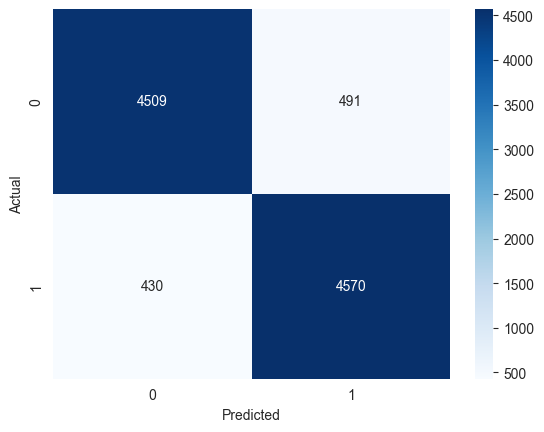

In [21]:
cm = confusion_matrix(y_test, y_pred_bi)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

- FN and FP are reduced

In [22]:
y_prob_bi = lr_bi.predict_proba(X_test_bi)[:,1]

roc_auc = roc_auc_score(y_test, y_prob_bi)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.96897056


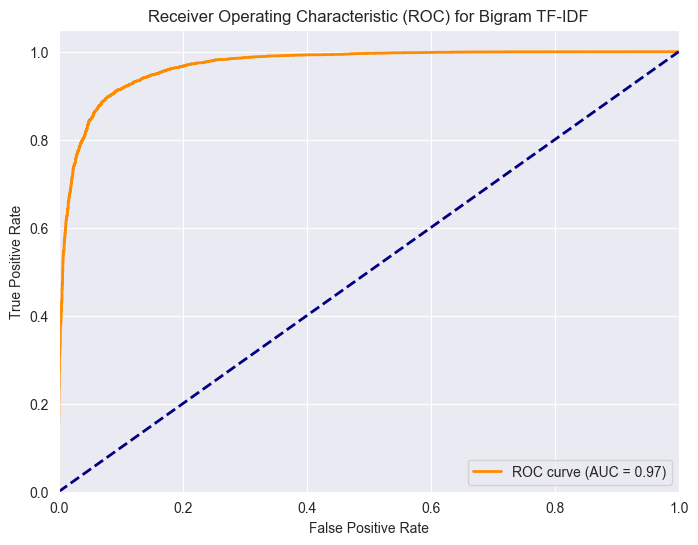

In [23]:
y_true_mapped = np.where(y_test == 'positive', 1, 0) # convert y_test to binary
fpr, tpr, _ = roc_curve(y_true_mapped, y_prob_bi)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Bigram TF-IDF')
plt.legend(loc="lower right")
plt.legend()

- Higher than unigram

In [24]:
feature_names = tfidf_bi.get_feature_names_out()
coef = lr_bi.coef_[0]

df_coef = pd.DataFrame({'word': feature_names, 'coef': coef})

top_20_neg = df_coef.sort_values(by='coef').head(20)

In [25]:
fig = px.bar(top_20_neg,
             x='coef',
             y='word',
             title='Top 20 Negative Words (Strongest Predictors)')

fig.show()

In [26]:
top_20_pos = df_coef.sort_values(by='coef').tail(20)

In [27]:
fig = px.bar(top_20_pos,
             x='coef',
             y='word',
             title='Top 20 Positive Words (Strongest Predictors)')

fig.show()

In [28]:
errors = X_test[
    y_test != y_pred_uni
].sample(5, random_state=42)

errors

45021    coming from oz i probably shouldn t say it but...
49471    an interesting thriller that has paul winfield...
27785    although i had seen gymkata in a theater way b...
29664    i went to see vanilla sky with a huge huge hug...
24127    i was having a horrid day but this movie grabb...
Name: clean_review, dtype: str

In [29]:
errors = X_test[
    y_test != y_pred_bi
    ].sample(5, random_state=42)

errors

25665    and yet another run of south park comes to an ...
43679    joan crawford is convincingly disfigured as ou...
45541    what s with indonesian musical movies never ha...
48505    i don t give much credence to aids conspiracy ...
23748    ok so there s always people out there that see...
Name: clean_review, dtype: str

In [38]:
import joblib

models_path = "../models/"

joblib.dump(X_train_uni, models_path + "X_train_uni.pkl")
joblib.dump(X_test_uni, models_path + "X_test_uni.pkl")
joblib.dump(X_train_bi, models_path + "X_train_bi.pkl")
joblib.dump(X_test_bi, models_path + "X_test_bi.pkl")
joblib.dump((X_train, X_test, y_train, y_test), models_path + "split_data.pkl")
joblib.dump(tfidf_uni, models_path + "tfidf_uni.pkl")
joblib.dump(tfidf_bi, models_path + "tfidf_bi.pkl")

print("Finished...")

Finished...


## Day 4 – Logistic Regression Baseline

- Logistic Regression provides a strong baseline for sentiment analysis
- Bigram slightly improves context but does not significantly outperform unigram for this baseline.
- Bigram improves context but increases feature space
- Common errors include sarcasm and implicit sentiment
